# Separate the filaments in N2Hp and HC3N

We know that the filament forks from south to north. Then, we know that there are two components that overlap each other. These correspond to two apparent layers in velocity, as suggested by the KDE of the velocities 

We will first separate the 1 Gaussian fit into the two sides of the filament. After testing DBSCAN, KMEANS, and HDBSCAN, DBSCAN gives the best results

In [1]:
import numpy as np
import pandas as pd
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
import os
import sys
sys.path.append('../')
from setup import *
import warnings
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib widget

from sklearn.cluster import KMeans, DBSCAN, HDBSCAN, OPTICS, cluster_optics_dbscan
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

import hdbscan # I want to test this one that has more complete functions

from tqdm.notebook import tqdm
seed = 42

run_DBSCAN = False
run_manual = False
run_HDBSCAN = True
run_OPTICS = False

In [2]:
# we first load our table of features
mol1 = 'N2Hp' # remember to do the bayes fitting for all hyperfine components
mol1_as_features_file = bayesfolder + 'nested-sampling/{0}/{0}_feature_table_bayes_QA.csv'.format(mol1)
mol1label = r'N$_2$H$^+$'
ncomp1 = 2
ncompfilebayes_mol1 = bayesfolder + 'nested-sampling/{}/npeaks_cut5_noislands_QA.fits'.format(mol1)

ds_mol1_feats = pd.read_csv(mol1_as_features_file)
ds_mol1_feats.rename(columns={'Unnamed: 0':'Index_original'}, inplace = True)
print('We have ', np.shape(ds_mol1_feats)[0], 'points for {}'.format(mol1))

mol2 = 'HC3N' 
mol2_as_features_file = bayesfolder + 'nested-sampling/{0}/{0}_feature_table_bayes_QA.csv'.format(mol2)
mol2label = r'HC$_3$N'
ncomp2 = 3
ncompfilebayes_mol2 = bayesfolder + 'nested-sampling/{}/npeaks_cut5_noislands_QA.fits'.format(mol2)

ds_mol2_feats = pd.read_csv(mol2_as_features_file)
ds_mol2_feats.rename(columns={'Unnamed: 0':'Index_original'}, inplace = True)
print('We have ', np.shape(ds_mol2_feats)[0], 'points for {}'.format(mol2))

We have  94864 points for N2Hp
We have  56771 points for HC3N


In [3]:
## lets do an extra filtering of N2Hp just in case
ds_mol1_feats = ds_mol1_feats.query('e_sigma_v/sigma_v < 0.5')
print('We have ', np.shape(ds_mol1_feats)[0], 'points for {}'.format(mol1) + 'after filtering error in sigma')
ds_mol1_feats = ds_mol1_feats.query('e_vlsr/vlsr < 0.5')
print('We have ', np.shape(ds_mol1_feats)[0], 'points for {}'.format(mol1) + 'after filtering error in velocity')
ds_mol1_feats = ds_mol1_feats.query('e_amplitude/amplitude < 0.5')
print('We have ', np.shape(ds_mol1_feats)[0], 'points for {}'.format(mol1) + 'after filtering error in velocity')

if not os.path.exists(mol1_as_features_file[:-4] + '_pandasQA.csv'): ds_mol1_feats.to_csv(mol1_as_features_file[:-4] + '_pandasQA.csv')
# we need to take the outflow enhanced pixels by hand

We have  91799 points for N2Hpafter filtering error in sigma
We have  91799 points for N2Hpafter filtering error in velocity
We have  91649 points for N2Hpafter filtering error in velocity


In [3]:
# for HC3N we will need to take out the points consisting on outflow
# we do an extra quality assessment to filter out components with high error
# its much easier doing this in pandas

ds_mol2_feats = ds_mol2_feats.query('e_sigma_v/sigma_v < 0.5')
print('We have ', np.shape(ds_mol2_feats)[0], 'points for {}'.format(mol2) + 'after filtering error in sigma')
ds_mol2_feats = ds_mol2_feats.query('e_vlsr/vlsr < 0.5')
print('We have ', np.shape(ds_mol2_feats)[0], 'points for {}'.format(mol2) + 'after filtering error in velocity')
ds_mol2_feats = ds_mol2_feats.query('e_amplitude/amplitude < 0.5')
print('We have ', np.shape(ds_mol2_feats)[0], 'points for {}'.format(mol2) + 'after filtering error in velocity')

if not os.path.exists(mol1_as_features_file[:-4] + '_pandasQA.csv'): ds_mol1_feats.to_csv(mol2_as_features_file[:-4] + '_pandasQA.csv')
# we need to take the outflow enhanced pixels by hand
ds_mol2_feats = ds_mol2_feats.query('vlsr < 9')
ds_mol2_feats = ds_mol2_feats.query('vlsr > 5')
ds_mol2_feats = ds_mol2_feats.query('sigma_v < 1')
print('We have ', np.shape(ds_mol2_feats)[0], 'points for {}'.format(mol2) + 'after filtering velocity and sigma of outflows')

print('We have ', np.shape(ds_mol2_feats)[0], 'points for {}'.format(mol2))


We have  53846 points for HC3Nafter filtering error in sigma
We have  53846 points for HC3Nafter filtering error in velocity
We have  53824 points for HC3Nafter filtering error in velocity
We have  52019 points for HC3Nafter filtering velocity and sigma of outflows
We have  52019 points for HC3N


In [4]:
# we select which columns we want to separate by
ds_cluster1_mol1 = ds_mol1_feats[['x_pix', 'y_pix', 'amplitude', 'vlsr', 'sigma_v']]
ds_cluster2_mol1 = ds_mol1_feats[['x_pix', 'y_pix', 'vlsr']]
ds_cluster3_mol1 = ds_mol1_feats[['x_pix', 'y_pix', 'vlsr', 'sigma_v']]

ds_cluster1_mol2 = ds_mol2_feats[['x_pix', 'y_pix', 'amplitude', 'vlsr', 'sigma_v']]
ds_cluster2_mol2 = ds_mol2_feats[['x_pix', 'y_pix', 'vlsr']]
ds_cluster3_mol2 = ds_mol2_feats[['x_pix', 'y_pix', 'vlsr', 'sigma_v']]
ds_cluster4_mol2 = ds_mol2_feats[['x_pix', 'y_pix', 'sigma_v']]

In [5]:
# we scale the features so that they are comparable
scaler1_mol1 = StandardScaler()
X1_mol1 = scaler1_mol1.fit_transform(ds_cluster1_mol1)
scaler2_mol1 = StandardScaler()
X2_mol1 = scaler2_mol1.fit_transform(ds_cluster2_mol1)
X2_mol1_weighted = X2_mol1 * np.array([0.25, 0.25, 0.5]) # we give more weight to velocity
scaler3_mol1 = StandardScaler()
X3_mol1 = scaler3_mol1.fit_transform(ds_cluster3_mol1)


scaler1_mol2 = StandardScaler()
X1_mol2 = scaler1_mol2.fit_transform(ds_cluster1_mol2)
scaler2_mol2 = StandardScaler()
X2_mol2 = scaler2_mol2.fit_transform(ds_cluster2_mol2)
X2_mol2_weight = X2_mol2 * np.array([0.25, 0.25, 0.5])
scaler3_mol2 = StandardScaler()
X3_mol2 = scaler3_mol2.fit_transform(ds_cluster3_mol2)
scaler4_mol2 = StandardScaler()
X4_mol2 = scaler4_mol2.fit_transform(ds_cluster4_mol2)

In [6]:
np.shape(ds_cluster1_mol2.values)


(52019, 5)

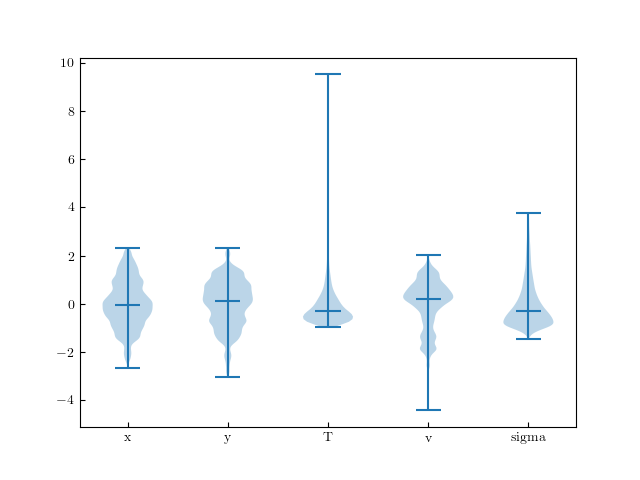

In [7]:
### after we scale, we can look at the ranges with the violin plot for HC3N

fig = plt.figure()
ax = fig.add_subplot(111)

ax.violinplot(dataset=[X1_mol2.T[0], X1_mol2.T[1], X1_mol2.T[2],X1_mol2.T[3], X1_mol2.T[4]], showmeans=False, showmedians=True)
ax.set_xticks([1, 2, 3, 4, 5], labels=['x', 'y', 'T', 'v', 'sigma'])
# ax.set_xticks([y + 1 for y in range(len(X1_mol2))], labels=['x']) #, 'y', 'T', 'v', 'sigma'

## DBSCAN

In [ ]:
if run_DBSCAN: 
    min_samples_mol1 = 1000
    min_samples_mol2 = 250

In [ ]:
# if run_DBSCAN:
#     # average distance between each point and its k nearest neighbors
#     neighbors_mol1 = NearestNeighbors(n_neighbors=min_samples_mol1, algorithm='kd_tree')
#     neighbors_mol1.fit(X2_mol1)
#     distances_mol1, indices_mol1 = neighbors_mol1.kneighbors(X2_mol1)
#     distances_mol1 = np.sort(distances_mol1, axis=0)
#     distances_mol1 = distances_mol1[:,1]
    
#     neighbors_mol2 = NearestNeighbors(n_neighbors=min_samples_mol2, algorithm='kd_tree')
#     neighbors_mol2.fit(X2_mol2)
#     distances_mol2, indices_mol2 = neighbors_mol2.kneighbors(X2_mol2)
#     distances_mol2 = np.sort(distances_mol2, axis=0)
#     distances_mol2 = distances_mol2[:,1]

In [ ]:
# if run_DBSCAN:
#     fig, [ax1, ax2] = plt.subplots(ncols=2,figsize=(6,4))
#     ax1.plot(distances_mol1)
#     ax1.set_xlabel('Points sorted by k-distance for {}'.format(mol1label))
#     ax1.set_ylabel('Average distance to k='+str(min_samples_mol1)+' nearest neighbors')
    
#     ax2.plot(distances_mol2)
#     ax2.set_xlabel('Points sorted by k-distance for {}'.format(mol2label))
#     ax2.set_ylabel('Average distance to k='+str(min_samples_mol2)+' nearest neighbors')

We found a good set of parameters for DBSCAN N2Hp: epsilon = 0.35, minsamples = 1000, gives 3 groups and noise looks reasonable. With this, the fork belongs to neither of the main groups. 

In [ ]:
if run_DBSCAN:
    db = DBSCAN(eps=0.352, min_samples=min_samples_mol1)
    
    db.fit(X2_mol1)
    labels = db.labels_
    ds_mol1_feats['labels_dbscan'] = labels
    ds_cluster2_mol1['labels_dbscan'] = labels
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)
    print("Total number of points: %d" % len(labels))
    # unique_labels = set(labels)

In [ ]:
if run_DBSCAN:
    unique_labels = set(labels)
    colors = [plt.cm.tab10(each) for each in np.linspace(0, 1, len(unique_labels))]

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('RA (pix)')
    ax.set_ylabel('DEC (pix)')
    ax.set_zlabel(r'v$_{lsr}$ (km s$^{-1}$)')

    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]
            # continue
        class_member_mask = labels == k
        if k==0: continue

        xy = scaler2_mol1.inverse_transform(X2_mol1[class_member_mask])
        ax.scatter(xy[:,0], xy[:,1], xy[:,2], s=4, color=col, alpha=0.2, label=k)
    # ax.scatter(ra_yso_pix, dec_yso_pix, vlsr_yso, s=50, color='r')
    ax.legend()

We know now that DBSCAN works best for N2Hp, now what we will do is check how many points are left as noise and if it is possible to cluster them. 

We first check how many components there are in each group

In [ ]:
if run_DBSCAN:

    clump0_mol1 = ds_mol1_feats[ds_cluster2_mol1['labels_dbscan']==0]
    clump1_mol1 = ds_mol1_feats[ds_cluster2_mol1['labels_dbscan']==1]
    rad_assign = 5
    vel_average = np.nanmean(ds_mol1_feats['vlsr'])
    tmb_average = np.nanmean(ds_mol1_feats['amplitude'])

Only by plotting we can see that there are some spots that have 2 components in the same group. We will filter these out using Spandan's algorithm.

In [ ]:
def dist_ar(xc=None, yc=None):
    """
    returns a 2D array with distance to each pixel from a custom centre pixel, (xc, yc)
    """
    d_ar = np.zeros(npeaks_map.shape)
    for i in range(d_ar.shape[0]):
        for j in range(d_ar.shape[1]):
            d_ar[i,j] = np.hypot(xc - j, yc - i)
        
    return d_ar

def para_dist(v1=None, v2=None, tmb1=None, tmb2=None, vel_norm=0.3, tmb_norm=3, w_vel=0.5):
    """
    returns normalised combined 'distance' in velocity and T_MB
    
    v1, v2 : velocities of the two pixels
    tmb1, tmb2 : main beam brightness temperatures of the two pixels
    
    vel_norm : normalisation factor for difference in velocities
    tmb_norm : normalisation factor for difference in T_MB
    
    w_vel : weight for velocity 'distance'. T_MB diff gets weight (1-w)

    """
    
    vl_dist = np.abs((v1 - v2) / vel_norm)
    tmb_dist = np.abs((tmb1 - tmb2) / tmb_norm)
    
    dist = np.hypot(vl_dist*w_vel, (1-w_vel)*tmb_dist)
    return dist


In [ ]:
if run_DBSCAN:
    for i in tqdm(clump0_mol1.index.values): # we check all the array
        try:
            cx, cy = clump0_mol1.loc[i, 'x_pix'], clump0_mol1.loc[i, 'y_pix']
        except KeyError:
            continue # found a value that was repeated and that its not there anymore
        query = clump0_mol1.query('x_pix=={0} & y_pix=={1}'.format(cx, cy))
        if len(query) > 1:
            index0, index1 = query.index.values
            vel1 = query.loc[index0, 'vlsr']
            tmb1 = query.loc[index0, 'amplitude']
            vel2 = query.loc[index1, 'vlsr']
            tmb2 = query.loc[index1, 'amplitude']
            rad_sample = clump0_mol1.query('x_pix>{0} & y_pix>{1} & x_pix<{2} & y_pix<{3}'.format(
                cx-rad_assign, cy-rad_assign, cx+rad_assign, cy+rad_assign))
            rad_sample.drop([index0, index1])
            vel_mean = np.mean(rad_sample['vlsr'])
            t_mean = np.mean(rad_sample['amplitude'])
            distances = para_dist(v1=np.array([vel1, vel2]), v2=vel_mean, tmb1=np.array([tmb1, tmb2]),
                                    tmb2=t_mean, vel_norm=vel_average, tmb_norm=tmb_average)
            if np.argmin(distances) == 0:
                index = query.loc[index1, 'Index_original']
                index2 = clump0_mol1.query('x_pix=={0} & y_pix=={1} & vlsr=={2}'.format(cx, cy, vel2)).index.values[0]
                ds_mol1_feats.loc[index, 'labels_dbscan'] = -1
                clump0_mol1 = clump0_mol1.drop([index2])
            elif np.argmin(distances) == 1:
                index = query.loc[index0, 'Index_original']
                index2 = clump0_mol1.query('x_pix=={0} & y_pix=={1} & vlsr=={2}'.format(cx, cy, vel1)).index.values[0]
                ds_mol1_feats.loc[index, 'labels_dbscan'] = -1
                clump0_mol1 = clump0_mol1.drop([index2])

In [ ]:
if run_DBSCAN:
    for i in tqdm(clump1_mol1.index.values): # we check all the array
        try:
            cx, cy = clump1_mol1.loc[i, 'x_pix'], clump1_mol1.loc[i, 'y_pix']
        except KeyError:
            continue # found a value that was repeated and that its not there anymore

        query = clump1_mol1.query('x_pix=={0} & y_pix=={1}'.format(cx, cy))
        if len(query) > 1:
            index0, index1 = query.index.values
            vel1 = query.loc[index0, 'vlsr']
            tmb1 = query.loc[index0, 'amplitude']
            vel2 = query.loc[index1, 'vlsr']
            tmb2 = query.loc[index1, 'amplitude']
            rad_sample = clump1_mol1.query('x_pix>{0} & y_pix>{1} & x_pix<{2} & y_pix<{3}'.format(
                cx-rad_assign, cy-rad_assign, cx+rad_assign, cy+rad_assign))
            rad_sample.drop([index0, index1])
            vel_mean = np.mean(rad_sample['vlsr'])
            t_mean = np.mean(rad_sample['amplitude'])
            distances = para_dist(v1=np.array([vel1, vel2]), v2=vel_mean, tmb1=np.array([tmb1, tmb2]),
                                    tmb2=t_mean, vel_norm=vel_average, tmb_norm=tmb_average)
            if np.argmin(distances) == 0:
                index = query.loc[index1, 'Index_original']
                index2 = clump1_mol1.query('x_pix=={0} & y_pix=={1} & vlsr=={2}'.format(cx, cy, vel2)).index.values[0]
                ds_mol1_feats.loc[index, 'labels_dbscan'] = -1
                clump1_mol1 = clump1_mol1.drop([index2])
            elif np.argmin(distances) == 1:
                index = query.loc[index0, 'Index_original']
                index2 = clump1_mol1.query('x_pix=={0} & y_pix=={1} & vlsr=={2}'.format(cx, cy, vel1)).index.values[0]
                ds_mol1_feats.loc[index, 'labels_dbscan'] = -1
                clump1_mol1 = clump1_mol1.drop([index2])

Just for now, we will save these groups. What we are missing is to check the noise points to not lose information.

In [ ]:
if run_DBSCAN:
    # we would now like to build some preliminary images
    cubefile_mol1 = '../bayes_frame/nested-sampling/{0}/NGC1333-SE-mle-x1_filtered_QA.fits'.format(mol1)
    cubefile_clump0 = 'cluster0_DBSCAN_{}.fits'.format(mol1)

    header_components_mol1 = fits.getheader(cubefile_mol1)
    cube_components_mol1 = np.zeros(np.shape(fits.getdata(cubefile_mol1))) * np.nan
    print('Saving clump 0')
    for i in tqdm(clump0_mol1.index.values):
        x = int(clump0_mol1.loc[i, 'x_pix'])
        y = int(clump0_mol1.loc[i, 'y_pix'])
        cube_components_mol1[0, y, x] = clump0_mol1.loc[i, 'amplitude']
        cube_components_mol1[1, y, x] = clump0_mol1.loc[i, 'vlsr']
        cube_components_mol1[2, y, x] = clump0_mol1.loc[i, 'sigma_v']
        cube_components_mol1[3, y, x] = clump0_mol1.loc[i, 'e_amplitude']
        cube_components_mol1[4, y, x] = clump0_mol1.loc[i, 'e_vlsr']
        cube_components_mol1[5, y, x] = clump0_mol1.loc[i, 'e_sigma_v']


    fits.writeto(cubefile_clump0, cube_components_mol1, header_components_mol1)

In [ ]:
if run_DBSCAN:
    cubefile_clump1 = 'cluster1_DBSCAN_{}.fits'.format(mol1)

    header_components_mol1 = fits.getheader(cubefile_mol1)
    cube1_components_mol1 = np.zeros(np.shape(fits.getdata(cubefile_mol1))) * np.nan
    # naxis1 = header_components_mol1['NAXIS1']
    # naxis2 = header_components_mol1['NAXIS2']
    # naxis3 = header_components_mol1['NAXIS3']

    # wcs = WCS(header)
    print('Saving clump 1')
    for i in tqdm(clump1_mol1.index.values):
        x = int(clump1_mol1.loc[i, 'x_pix'])
        y = int(clump1_mol1.loc[i, 'y_pix'])
        cube1_components_mol1[0, y, x] = clump1_mol1.loc[i, 'amplitude']
        cube1_components_mol1[1, y, x] = clump1_mol1.loc[i, 'vlsr']
        cube1_components_mol1[2, y, x] = clump1_mol1.loc[i, 'sigma_v']
        cube1_components_mol1[3, y, x] = clump1_mol1.loc[i, 'e_amplitude']
        cube1_components_mol1[4, y, x] = clump1_mol1.loc[i, 'e_vlsr']
        cube1_components_mol1[5, y, x] = clump1_mol1.loc[i, 'e_sigma_v']


    fits.writeto(cubefile_clump1, cube1_components_mol1, header_components_mol1)

All of the above was for N2Hp (molecule 1). Now we do the same for HC3N (molecule 2).

Maybe with HC3N an artificial separation at 7.5 km/s can suffice, as it is quite hard to interpret the clusters being obtained.

We got good results with epsilon=0.188 and min_samples=250

In [ ]:
if run_DBSCAN:
    db2 = DBSCAN(eps=0.188, min_samples=min_samples_mol2)
    
    db2.fit(X2_mol2)
    labels = db2.labels_
    ds_mol2_feats['labels_dbscan'] = labels
    ds_cluster2_mol2['labels_dbscan'] = labels
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)
    print("Total number of points: %d" % len(labels))
    # unique_labels = set(labels)

In [ ]:
if run_DBSCAN:
    unique_labels = set(labels)
    colors = [plt.cm.viridis(each) for each in np.linspace(0, 1, len(unique_labels))]

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('RA (pix)')
    ax.set_ylabel('DEC (pix)')
    ax.set_zlabel(r'v$_{lsr}$ (km s$^{-1}$)')

    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]
            # continue
        class_member_mask = labels == k

        xy = scaler2_mol2.inverse_transform(X2_mol2[class_member_mask])
        ax.scatter(xy[:,0], xy[:,1], xy[:,2], s=4, color=col, alpha=0.2, label=k)
    # ax.scatter(ra_yso_pix, dec_yso_pix, vlsr_yso, s=50, color='r')
    ax.legend()

### DBSCAN test with more parameters
We know now that with x, y and velocity we can have certain layers, but how does it look like when we include the dispersion?

We are interested in this kind of grouping as if the dispersion tends to increase toward SVS13, this could support the idea that the north is affected by a wave coming from a bubble toward the north. However, this test is not relevant to detect diverging flows between the molecules, so only the x, y, vel is relevant to our goal. 

In [ ]:
# if run_DBSCAN: min_samples = 200

In [ ]:
# if run_DBSCAN:
#     #average distance between each point and its k nearest neighbors
#     neighbors = NearestNeighbors(n_neighbors=min_samples, algorithm='kd_tree')
#     neighbors.fit(X3)
#     distances, indices = neighbors.kneighbors(X3)
#     distances = np.sort(distances, axis=0)
#     distances = distances[:,1]

In [ ]:
# if run_DBSCAN:
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     ax.plot(distances)
#     ax.set_xlabel('Points sorted by k-distance for {} neighbors'.format(min_samples))
#     ax.set_ylabel('Average distance to k='+str(min_samples)+' nearest neighbors')

In [ ]:
# if run_DBSCAN:
#     db = DBSCAN(eps=0.25, min_samples=min_samples)
    
#     db.fit(X3)
#     labels = db.labels_
#     ds_cluster3['labels_dbscan'] = labels
#     n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
#     n_noise_ = list(labels).count(-1)

#     print("Estimated number of clusters: %d" % n_clusters_)
#     print("Estimated number of noise points: %d" % n_noise_)
#     print("Total number of points: %d" % len(labels))
#     # unique_labels = set(labels)

In [ ]:
# if run_DBSCAN:
#     unique_labels = set(labels)
#     colors = [plt.cm.inferno(each) for each in np.linspace(0, 1, len(unique_labels))]

#     fig = plt.figure(figsize=(8,8))
#     ax = fig.add_subplot(111, projection='3d')
#     ax.set_xlabel('RA (pix)')
#     ax.set_ylabel('DEC (pix)')
#     ax.set_zlabel(r'v$_{lsr}$ (km s$^{-1}$)')

#     for k, col in zip(unique_labels, colors):
#         if k == -1:
#             # Black used for noise.
#             col = [0, 0, 0, 1]
#             continue
#         class_member_mask = labels == k

#         xy = scaler3.inverse_transform(X3[class_member_mask])
#         ax.scatter(xy[:,0], xy[:,1], xy[:,2], s=4, color=col, alpha=0.2, label=k)
#     # ax.scatter(ra_yso_pix, dec_yso_pix, vlsr_yso, s=50, color='r')
#     ax.legend()

We can recover some of the noise points, but we can see that adding the dispersion independant of the eps and min_samples will always separate the north into smaller groups from the south.


## Manual separation

We do this for HC3N.

The approach right now has an issue: when sampling in the radius, it takes all the repeated components as well. 

In [ ]:
if run_manual:
    clump0_mol2 = ds_mol2_feats.query('vlsr > 7.5')
    clump1_mol2 = ds_mol2_feats.query('vlsr <= 7.5')
    # now we run Spandan's algorithm of distance
    rad_assign = 5
    vel_average = np.nanmean(ds_mol2_feats['vlsr'])
    tmb_average = np.nanmean(ds_mol2_feats['amplitude'])
    for i in tqdm(clump0_mol2.index.values): # we check all the array
        try:
            cx, cy = clump0_mol2.loc[i, 'x_pix'], clump0_mol2.loc[i, 'y_pix']
        except KeyError:
            continue # found a value that was repeated and that its not there anymore
        query = clump0_mol2.query('x_pix=={0} & y_pix=={1}'.format(cx, cy))
        if len(query) > 1:
            #it could happen that there are 3 components: 
            if len(query) > 2: index0, index1, index2 = query.index.values
            else: index0, index1 = query.index.values
            vel1 = query.loc[index0, 'vlsr']
            tmb1 = query.loc[index0, 'amplitude']
            vel2 = query.loc[index1, 'vlsr']
            tmb2 = query.loc[index1, 'amplitude']
            if len(query) > 2: 
                vel3 = query.loc[index2, 'vlsr']
                tmb3 = query.loc[index2, 'amplitude']
            #here fix
            rad_sample = clump0_mol2.query('x_pix>{0} & y_pix>{1} & x_pix<{2} & y_pix<{3}'.format(
                cx-rad_assign, cy-rad_assign, cx+rad_assign, cy+rad_assign))
            
            rad_sample.drop([index0, index1])
            if len(query) > 2: rad_sample.drop([index2])
            vel_mean = np.mean(rad_sample['vlsr'])
            t_mean = np.mean(rad_sample['amplitude'])
            if len(query) > 2: 
                distances = para_dist(v1=np.array([vel1, vel2, vel3]), v2=vel_mean, tmb1=np.array([tmb1, tmb2, tmb3]),
                                      tmb2=t_mean, vel_norm=vel_average, tmb_norm=tmb_average)
            else:
                distances = para_dist(v1=np.array([vel1, vel2]), v2=vel_mean, tmb1=np.array([tmb1, tmb2]),
                                      tmb2=t_mean, vel_norm=vel_average, tmb_norm=tmb_average)
            if np.argmin(distances) == 0:
                index = query.loc[index1, 'Index_original']
                indexaux = clump0_mol2.query('x_pix=={0} & y_pix=={1} & vlsr=={2}'.format(cx, cy, vel2)).index.values[0]
                ds_mol2_feats.loc[index, 'labels_dbscan'] = -1
                clump0_mol2 = clump0_mol2.drop([indexaux])
                if len(query) > 2:
                    index = query.loc[index2, 'Index_original']
                    indexaux = clump0_mol2.query('x_pix=={0} & y_pix=={1} & vlsr=={2}'.format(cx, cy, vel3)).index.values[0]
                    ds_mol2_feats.loc[index, 'labels_dbscan'] = -1
                    clump0_mol2 = clump0_mol2.drop([indexaux])
            elif np.argmin(distances) == 1:
                index = query.loc[index0, 'Index_original']
                indexaux = clump0_mol2.query('x_pix=={0} & y_pix=={1} & vlsr=={2}'.format(cx, cy, vel1)).index.values[0]
                ds_mol2_feats.loc[index, 'labels_dbscan'] = -1
                clump0_mol2 = clump0_mol2.drop([indexaux])
                if len(query) > 2:
                    index = query.loc[index2, 'Index_original']
                    indexaux = clump0_mol2.query('x_pix=={0} & y_pix=={1} & vlsr=={2}'.format(cx, cy, vel3)).index.values[0]
                    ds_mol2_feats.loc[index, 'labels_dbscan'] = -1
                    clump0_mol2 = clump0_mol2.drop([indexaux])
            if len(query) > 2:
                if np.argmin(distances) == 2:
                    index = query.loc[index1, 'Index_original']
                    indexaux = clump0_mol2.query('x_pix=={0} & y_pix=={1} & vlsr=={2}'.format(cx, cy, vel2)).index.values[0]
                    ds_mol2_feats.loc[index, 'labels_dbscan'] = -1
                    clump0_mol2 = clump0_mol2.drop([indexaux])
                    index = query.loc[index0, 'Index_original']
                    indexaux = clump0_mol2.query('x_pix=={0} & y_pix=={1} & vlsr=={2}'.format(cx, cy, vel1)).index.values[0]
                    ds_mol2_feats.loc[index, 'labels_dbscan'] = -1
                    clump0_mol2 = clump0_mol2.drop([indexaux])

In [ ]:
if run_manual:
    for i in tqdm(clump1_mol2.index.values): # we check all the array
        try:
            cx, cy = clump1_mol2.loc[i, 'x_pix'], clump1_mol2.loc[i, 'y_pix']
        except KeyError:
            continue # found a value that was repeated and that its not there anymore
        query = clump1_mol2.query('x_pix=={0} & y_pix=={1}'.format(cx, cy))
        if len(query) > 1:
            #it could happen that there are 3 components: 
            if len(query) > 2: index0, index1, index2 = query.index.values
            else: index0, index1 = query.index.values
            vel1 = query.loc[index0, 'vlsr']
            tmb1 = query.loc[index0, 'amplitude']
            vel2 = query.loc[index1, 'vlsr']
            tmb2 = query.loc[index1, 'amplitude']
            if len(query) > 2: 
                vel3 = query.loc[index2, 'vlsr']
                tmb3 = query.loc[index2, 'amplitude']
            rad_sample = clump1_mol2.query('x_pix>{0} & y_pix>{1} & x_pix<{2} & y_pix<{3}'.format(
                cx-rad_assign, cy-rad_assign, cx+rad_assign, cy+rad_assign))
            
            rad_sample.drop([index0, index1])
            if len(query) > 2: rad_sample.drop([index2])
            vel_mean = np.mean(rad_sample['vlsr'])
            t_mean = np.mean(rad_sample['amplitude'])
            if len(query) > 2: 
                distances = para_dist(v1=np.array([vel1, vel2, vel3]), v2=vel_mean, tmb1=np.array([tmb1, tmb2, tmb3]),
                                      tmb2=t_mean, vel_norm=vel_average, tmb_norm=tmb_average)
            else:
                distances = para_dist(v1=np.array([vel1, vel2]), v2=vel_mean, tmb1=np.array([tmb1, tmb2]),
                                      tmb2=t_mean, vel_norm=vel_average, tmb_norm=tmb_average)
            if np.argmin(distances) == 0:
                index = query.loc[index1, 'Index_original']
                indexaux = clump1_mol2.query('x_pix=={0} & y_pix=={1} & vlsr=={2}'.format(cx, cy, vel2)).index.values[0]
                ds_mol2_feats.loc[index, 'labels_dbscan'] = -1
                clump1_mol2 = clump1_mol2.drop([indexaux])
                if len(query) > 2:
                    index = query.loc[index2, 'Index_original']
                    indexaux = clump1_mol2.query('x_pix=={0} & y_pix=={1} & vlsr=={2}'.format(cx, cy, vel3)).index.values[0]
                    ds_mol2_feats.loc[index, 'labels_dbscan'] = -1
                    clump1_mol2 = clump1_mol2.drop([indexaux])
            elif np.argmin(distances) == 1:
                index = query.loc[index0, 'Index_original']
                indexaux = clump1_mol2.query('x_pix=={0} & y_pix=={1} & vlsr=={2}'.format(cx, cy, vel1)).index.values[0]
                ds_mol2_feats.loc[index, 'labels_dbscan'] = -1
                clump1_mol2 = clump1_mol2.drop([indexaux])
                if len(query) > 2:
                    index = query.loc[index2, 'Index_original']
                    indexaux = clump1_mol2.query('x_pix=={0} & y_pix=={1} & vlsr=={2}'.format(cx, cy, vel3)).index.values[0]
                    ds_mol2_feats.loc[index, 'labels_dbscan'] = -1
                    clump1_mol2 = clump1_mol2.drop([indexaux])
            if len(query) > 2:
                if np.argmin(distances) == 2:
                    index = query.loc[index1, 'Index_original']
                    indexaux = clump1_mol2.query('x_pix=={0} & y_pix=={1} & vlsr=={2}'.format(cx, cy, vel2)).index.values[0]
                    ds_mol2_feats.loc[index, 'labels_dbscan'] = -1
                    clump1_mol2 = clump1_mol2.drop([indexaux])
                    index = query.loc[index0, 'Index_original']
                    indexaux = clump1_mol2.query('x_pix=={0} & y_pix=={1} & vlsr=={2}'.format(cx, cy, vel1)).index.values[0]
                    ds_mol2_feats.loc[index, 'labels_dbscan'] = -1
                    clump1_mol2 = clump1_mol2.drop([indexaux]) 

In [ ]:
if run_manual:
    cubefile_mol2 = '../bayes_frame/nested-sampling/{0}/NGC1333-SE-mle-x1_filtered_QA.fits'.format(mol2)
    cubefile_clump0 = 'cluster0_manual_{}.fits'.format(mol2)

    header_components_mol2 = fits.getheader(cubefile_mol2)
    cube_components_mol2 = np.zeros(np.shape(fits.getdata(cubefile_mol2))) * np.nan
    print('Saving clump 0 {}'.format(mol2))
    for i in tqdm(clump0_mol2.index.values):
        x = int(clump0_mol2.loc[i, 'x_pix'])
        y = int(clump0_mol2.loc[i, 'y_pix'])
        cube_components_mol2[0, y, x] = clump0_mol2.loc[i, 'amplitude']
        cube_components_mol2[1, y, x] = clump0_mol2.loc[i, 'vlsr']
        cube_components_mol2[2, y, x] = clump0_mol2.loc[i, 'sigma_v']
        cube_components_mol2[3, y, x] = clump0_mol2.loc[i, 'e_amplitude']
        cube_components_mol2[4, y, x] = clump0_mol2.loc[i, 'e_vlsr']
        cube_components_mol2[5, y, x] = clump0_mol2.loc[i, 'e_sigma_v']


    fits.writeto(cubefile_clump0, cube_components_mol2, header_components_mol2)

In [ ]:
if run_manual:
    cubefile_mol2 = '../bayes_frame/nested-sampling/{0}/NGC1333-SE-mle-x1_filtered_QA.fits'.format(mol2)
    cubefile_clump1 = 'cluster1_manual_{}.fits'.format(mol2)

    header_components_mol2 = fits.getheader(cubefile_mol2)
    cube_components_mol2 = np.zeros(np.shape(fits.getdata(cubefile_mol2))) * np.nan
    print('Saving clump 1 {}'.format(mol2))
    for i in tqdm(clump1_mol2.index.values):
        x = int(clump1_mol2.loc[i, 'x_pix'])
        y = int(clump1_mol2.loc[i, 'y_pix'])
        cube_components_mol2[0, y, x] = clump1_mol2.loc[i, 'amplitude']
        cube_components_mol2[1, y, x] = clump1_mol2.loc[i, 'vlsr']
        cube_components_mol2[2, y, x] = clump1_mol2.loc[i, 'sigma_v']
        cube_components_mol2[3, y, x] = clump1_mol2.loc[i, 'e_amplitude']
        cube_components_mol2[4, y, x] = clump1_mol2.loc[i, 'e_vlsr']
        cube_components_mol2[5, y, x] = clump1_mol2.loc[i, 'e_sigma_v']


    fits.writeto(cubefile_clump1, cube_components_mol2, header_components_mol2)

In [ ]:
# clump0_mol2.plot.scatter('x_pix', 'y_pix', alpha=0.2)

## HDBSCAN

In [ ]:
if run_HDBSCAN:
    min_cluster_size_hdb = 150
    min_samples_hdb = 102

In [ ]:
if run_HDBSCAN:
    # hdb = HDBSCAN(min_cluster_size = min_cluster_size_hdb, min_samples = min_samples_hdb)
    # hdb.fit(X2)
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size_hdb, gen_min_span_tree=True)
    clusterer.fit(X2_mol1) # what if we use all parameters?
    
    # labelshdb = hdb.labels_
    # ds_cluster2['labels_hdbscan'] = labelshdb

In [ ]:
fig, ax = plt.subplots()
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette(), axis=ax)


In [ ]:
if run_HDBSCAN:
    labels = clusterer.labels_
    # ds_mol1_feats['labels_hdbscan'] = labels
    # ds_cluster2_mol1['labels_hdbscan'] = labels
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)
    print("Total number of points: %d" % len(labels))
    # unique_labels = set(labels)

In [ ]:
if run_HDBSCAN:
    unique_labels = set(labels)
    colors = [plt.cm.tab10(each) for each in np.linspace(0, 1, len(unique_labels))]

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('RA (pix)')
    ax.set_ylabel('DEC (pix)')
    ax.set_zlabel(r'v$_{lsr}$ (km s$^{-1}$)')

    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]
            # continue
        class_member_mask = labels == k

        xy = scaler2_mol1.inverse_transform(X2_mol1[class_member_mask])
        ax.scatter(xy[:,0], xy[:,1], xy[:,2], s=4, color=col, alpha=0.2, label=k)
    # ax.scatter(ra_yso_pix, dec_yso_pix, vlsr_yso, s=50, color='r')
    ax.legend()

All above was for N2Hp, we can now try with HC3N


In [ ]:
if run_HDBSCAN:
    # hdb = HDBSCAN(min_cluster_size = min_cluster_size_hdb, min_samples = min_samples_hdb)
    # hdb.fit(X2)
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size_hdb, min_samples=min_samples_hdb, gen_min_span_tree=True)
    clusterer.fit(X2_mol2_weight) # what if we use all parameters?
    
    # labelshdb = hdb.labels_
    # ds_cluster2['labels_hdbscan'] = labelshdb

In [ ]:
fig, ax = plt.subplots()
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette(), axis=ax)


In [ ]:
if run_HDBSCAN:
    labels = clusterer.labels_
    # ds_mol2_feats['labels_hdbscan'] = labels
    # ds_cluster2_mol2['labels_hdbscan'] = labels
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)
    print("Total number of points: %d" % len(labels))
    # unique_labels = set(labels)

In [ ]:
if run_HDBSCAN:
    unique_labels = set(labels)
    # palette = sns.color_palette()
    # colors = [sns.desaturate(palette[col], sat)
    #               if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
    #               zip(clusterer.labels_, clusterer.probabilities_)]
    colors = [plt.cm.tab20(each) for each in np.linspace(0, 1, len(unique_labels))]

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('RA (pix)')
    ax.set_ylabel('DEC (pix)')
    ax.set_zlabel(r'v$_{lsr}$ (km s$^{-1}$)')
    
    # xy = scaler2_mol2.inverse_transform(X2_mol2)
    # ax.scatter(xy[:,0], xy[:,1], xy[:,2], s=4, color=colors, alpha=0.2)

    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]
            # continue
        class_member_mask = labels == k

        xy = scaler2_mol2.inverse_transform(X2_mol2[class_member_mask])
        ax.scatter(xy[:,0], xy[:,1], xy[:,2], s=4, color=col, alpha=0.2, label=k)
    # ax.scatter(ra_yso_pix, dec_yso_pix, vlsr_yso, s=50, color='r')
    ax.legend()

### HDBSCAN from sklearn

In [ ]:
if run_HDBSCAN:
    n_clusters_ = len(set(labelshdb)) - (1 if -1 in labelshdb else 0)
    n_noise_ = list(labelshdb).count(-1)
    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)
    print("Total number of points: %d" % len(labelshdb))

    labelshdb_cut =  hdb.dbscan_clustering(cut_distance=0.352)
    n_clusters_cut = len(set(labelshdb_cut)) - (1 if -1 in labelshdb_cut else 0)
    n_noise_cut = list(labelshdb_cut).count(-1)
    print("Estimated number of clusters in level: %d" % n_clusters_cut)
    print("Estimated number of noise points in level: %d" % n_noise_cut)

In [ ]:
# lets test the different layers of the Hierarchy

if run_HDBSCAN:
    unique_labels = set(labelshdb_cut)
    colors = [plt.cm.viridis(each) for each in np.linspace(0, 1, len(unique_labels))]

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('RA (pix)')
    ax.set_ylabel('DEC (pix)')
    ax.set_zlabel(r'v$_{lsr}$ (km s$^{-1}$)')

    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]
            continue
        class_member_mask = labelshdb_cut == k
        # if k ==2: continue
        xy = scaler2.inverse_transform(X2[class_member_mask])
        ax.scatter(xy[:,0], xy[:,1], xy[:,2], s=4, color=col, alpha=0.2, label=k)
    # ax.scatter(ra_yso_pix, dec_yso_pix, vlsr_yso, s=50, color='r')
    ax.legend()

## OPTICS

HDBSCAN is known as a mixture of DBSCAN and OPTICS, where the latter is the one that brings the variable density clustering. Lets try it to see if we can understand better what it is doing (without the minimum size cluster parameter that HDBSCAN has, it could help be less biased)

In [ ]:
if run_OPTICS:
    min_samples = 100
    min_cluster_size = 1000
    xi = 0.05
    max_eps = 0.38
    np.random.seed(seed)


In [ ]:
ds_cluster3 = ds_mol1_feats[ds_mol1_feats['x_pix']<130]
ds_cluster3 = ds_cluster3[ds_cluster3['y_pix']<130]
scaler3 = StandardScaler()
X3 = X2 #scaler3.fit_transform(ds_cluster3)

In [ ]:
if run_OPTICS: 
    clust = OPTICS(min_samples=min_samples, xi=xi, max_eps=max_eps, n_jobs=4, min_cluster_size=min_cluster_size)
    clust.fit(X3)

In [ ]:
if run_OPTICS:
    space = np.arange(len(X3))
    reachability = clust.reachability_[clust.ordering_]
    labels = clust.labels_[clust.ordering_]
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)
    print("Total number of points: %d" % len(labels))


In [ ]:
len(reachability)

In [ ]:
if run_OPTICS:
    
    labels_035 = cluster_optics_dbscan(
        reachability=clust.reachability_,
        core_distances=clust.core_distances_,
        ordering=clust.ordering_,
        eps=0.35,
    )
    labels_020 = cluster_optics_dbscan(
        reachability=clust.reachability_,
        core_distances=clust.core_distances_,
        ordering=clust.ordering_,
        eps=0.2,
    )



In [ ]:
if run_OPTICS:

    plt.figure(figsize=(10, 7))
    G = gridspec.GridSpec(2, 3)
    ax1 = plt.subplot(G[0, :])
    ax2 = plt.subplot(G[1, 0])
    ax3 = plt.subplot(G[1, 1])
    ax4 = plt.subplot(G[1, 2])

    # Reachability plot
    colors = ["g.", "r.", "b.", "y.", "c."]
    for klass, color in zip(range(0, 5), colors):
        Xk = space[labels == klass]
        Rk = reachability[labels == klass]
        ax1.plot(Xk, Rk, color, alpha=0.3)
    ax1.plot(space[labels == -1], reachability[labels == -1], "k.", alpha=0.3)
    ax1.plot(space, np.full_like(space, 0.35, dtype=float), "k-", alpha=0.5)
    ax1.plot(space, np.full_like(space, 0.2, dtype=float), "k-.", alpha=0.5)
    ax1.set_ylabel("Reachability (epsilon distance)")
    ax1.set_title("Reachability Plot")
    
    colors = ["g.", "r.", "b.", "y.", "c."]
    for klass, color in zip(range(0, 5), colors):
        Xk = X3[clust.labels_ == klass]
        ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
    ax2.plot(X3[clust.labels_ == -1, 0], X3[clust.labels_ == -1, 1], "k+", alpha=0.1)
    ax2.set_title("Automatic Clustering\nOPTICS")

    # DBSCAN at 0.5
    colors = ["g.", "r.", "b.", "c."]
    for klass, color in zip(range(0, 4), colors):
        Xk = X3[labels_035 == klass]
        ax3.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
    ax3.plot(X3[labels_035 == -1, 0], X3[labels_035 == -1, 1], "k+", alpha=0.1)
    ax3.set_title("Clustering at 0.35 epsilon cut\nDBSCAN")

    # DBSCAN at 2.
    colors = ["g.", "m.", "y.", "c."]
    for klass, color in zip(range(0, 4), colors):
        Xk = X3[labels_020 == klass]
        ax4.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
    ax4.plot(X3[labels_020 == -1, 0], X3[labels_020 == -1, 1], "k+", alpha=0.1)
    ax4.set_title("Clustering at 0.2 epsilon cut\nDBSCAN")
